In [1]:
# Cartpole game, as per https://keon.io/deep-q-learning/ 

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
ENV_NAME = "CartPole-v1"

MAXRUNS = 150
#NSTEPSOLVED = 1000

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   # 0.995 --> 1% after ~35 runs

In [3]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        # Get predicted qualities for each possible action, and return the action index with the highest quality
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:
            # Define the quality of the chosen action:
            #  - get the highest 'predicted quality' (out of all actions) for the future state
            #  - quality = this (times 'future discount factor') + current real reward
            #    (but if terminal: quality = reward, which should be low on termination)
            #  E.g. for cartpole: reward is always 1 unless terminal, then it is -1.
            #   --> if terminal: quality = -1 --> training will try to put predicted quality low for this state+action
            #   --> if not: predictions for n+1 are [quality left, quality right] = [0.22, 0.76] --> quality = 1.76
            #   --> but if both predictions for n+1 are low, e.g. [0.02, -0.50], it means it will probably terminate
            #       at the next iteration, making this a bad move --> quality for current move = 1.02 (is not so high)
            
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
                # Above, you can see that cartpole only directly learns from potential termination in the current step.
                #  As the model learns to give this situation a low quality, any step leading up to this state will get a 
                #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.
                # However, one could try to make the model learn from intermediate steps directly as well, speeding up the learning,
                #  e.g. by changing the reward based on an increase in angle (although this should really be defined in the env. conditions)
                #q_update -= 1.0 * abs(state_next[0][2]) - abs(state[0][2]) # penalize angle increases for cartpole
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the obtained reward, + future predicted quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between predictions and qualities.
            # - For the chosen action, this is f[(reward + future prediction) - current prediction]
            # - For the not-chosen action, this means try to not change the current prediction.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [4]:
def cartpole() :
    env = gym.make(ENV_NAME)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            env.render() # graphical output
            #action = env.action_space.sample() # (this takes a random action)
            action = dqn_solver.act(state) 
            
            state_next, reward, terminal, info = env.step(action)
            reward = reward if not terminal else -reward  # if action made terminal: reduce reward!
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal) # fill agent memory with this action's results
            state = state_next
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]
                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made
            
            #if(step > NSTEPSOLVED) :
            #    i = MAXRUNS
            #    print("Solved! (step > NSTEPSOLVED)")
            #    break

    env.close()
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure
    

Run: 1, exploration: 1.000000000000000, score: 13

Run: 2, exploration: 0.965520646809484, score: 14
Run: 3, exploration: 0.851801859600347, score: 26
Run: 4, exploration: 0.643326002771524, score: 57
Run: 5, exploration: 0.602741584308274, score: 14
Run: 6, exploration: 0.553507523032289, score: 18
Run: 7, exploration: 0.534422941652051, score: 8
Run: 8, exploration: 0.505753598389791, score: 12
Run: 9, exploration: 0.483444593917636, score: 10
Run: 10, exploration: 0.455222455512305, score: 13
Run: 11, exploration: 0.426504607098301, score: 14
Run: 12, exploration: 0.255786702284222, score: 103
Run: 13, exploration: 0.202098345386170, score: 48
Run: 14, exploration: 0.160481314204161, score: 47
Run: 15, exploration: 0.123040404923250, score: 54
Run: 16, exploration: 0.062540831695750, score: 136
Run: 17, exploration: 0.049662132773908, score: 47
Run: 18, exploration: 0.037319942779450, score: 58
Run: 19, exploration: 0.027350922279686, score: 63
Run: 20, exploration: 0.01733294357728

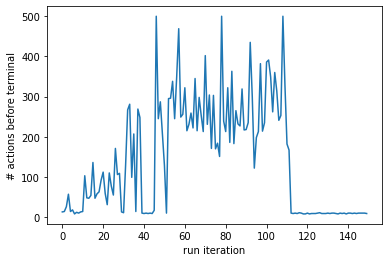

In [5]:
if __name__ == "__main__":
    cartpole()